<ipython-input-3-055a634f5c34>:43: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_data['MA7'] = train_data['Close'].rolling(window=7).mean().fillna(method='bfill')
<ipython-input-3-055a634f5c34>:44: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test_data['MA7'] = test_data['Close'].rolling(window=7).mean().fillna(method='bfill')


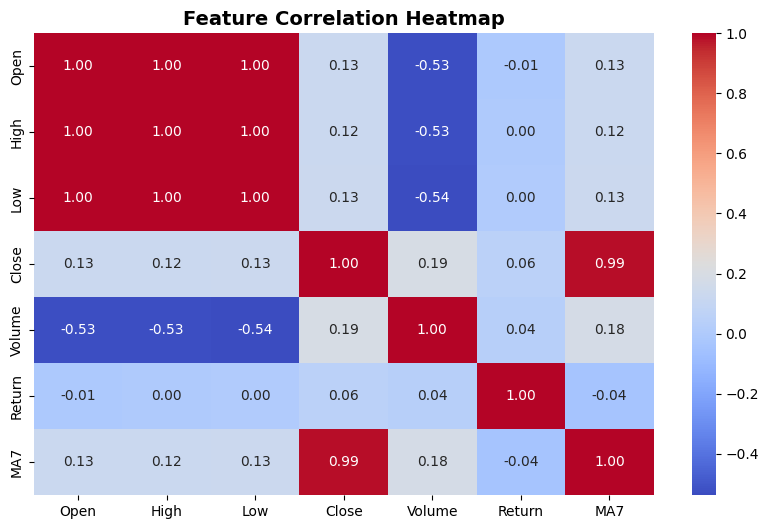

Starting Cross-Validation for RNN_50units_1layer_dropout0.0...
Fold 1/3
Early stopping at epoch 15
Fold 1 Validation Loss: 1.060732

Fold 2/3
Early stopping at epoch 55
Fold 2 Validation Loss: 0.005287

Fold 3/3
Early stopping at epoch 43
Fold 3 Validation Loss: 0.004237

Completed Cross-Validation for RNN_50units_1layer_dropout0.0

Starting Cross-Validation for RNN_100units_2layers_dropout0.2...
Fold 1/3
Early stopping at epoch 16
Fold 1 Validation Loss: 0.836517

Fold 2/3
Early stopping at epoch 40
Fold 2 Validation Loss: 0.004896

Fold 3/3
Early stopping at epoch 16
Fold 3 Validation Loss: 0.005447

Completed Cross-Validation for RNN_100units_2layers_dropout0.2

Starting Cross-Validation for RNN_200units_2layers_dropout0.1...
Fold 1/3
Early stopping at epoch 9
Fold 1 Validation Loss: 0.866791

Fold 2/3
Early stopping at epoch 37
Fold 2 Validation Loss: 0.003938

Fold 3/3
Early stopping at epoch 29
Fold 3 Validation Loss: 0.003640

Completed Cross-Validation for RNN_200units_2layers_

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Early stopping at epoch 12
Fold 1 Validation Loss: 0.900537

Fold 2/3
Early stopping at epoch 34
Fold 2 Validation Loss: 0.005944

Fold 3/3
Early stopping at epoch 28
Fold 3 Validation Loss: 0.004091

Completed Cross-Validation for GRU_200units_1layer_dropout0.1


Cross-Validation Results:
RNN_50units_1layer_dropout0.0: Avg Val MSE = 0.356752
RNN_100units_2layers_dropout0.2: Avg Val MSE = 0.282287
RNN_200units_2layers_dropout0.1: Avg Val MSE = 0.291457
LSTM_50units_1layer_dropout0.0: Avg Val MSE = 0.459570
LSTM_100units_2layers_dropout0.2: Avg Val MSE = 0.369948
LSTM_200units_2layers_dropout0.3: Avg Val MSE = 0.352944
GRU_50units_1layer_dropout0.0: Avg Val MSE = 0.356626
GRU_100units_2layers_dropout0.2: Avg Val MSE = 0.355144
GRU_200units_1layer_dropout0.1: Avg Val MSE = 0.303524

Best model from CV: RNN_100units_2layers_dropout0.2
Early stopping at epoch 48
Test MSE: 69.0424, MAE: 6.4003, MAPE: 0.79%

Baseline Performance:
Baseline MSE: 58.9329
Baseline MAE: 5.4785
Baseline MAPE: 0.68

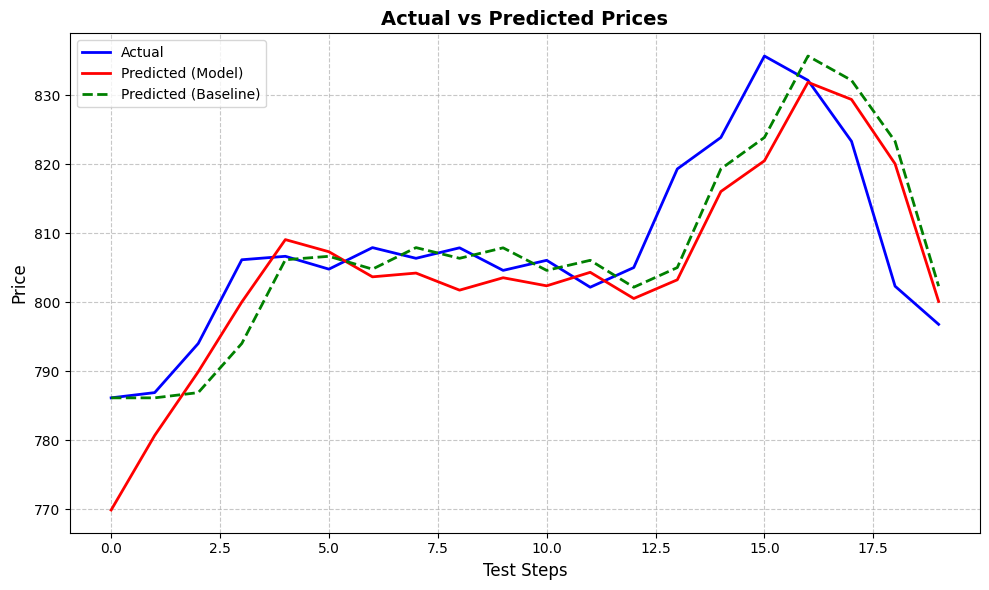

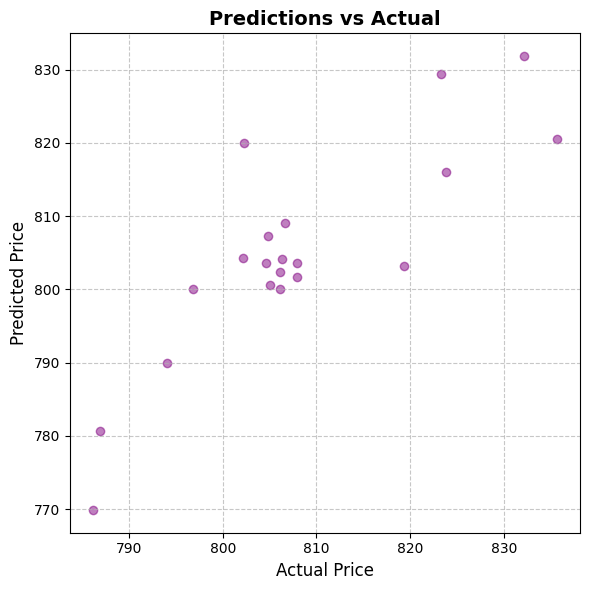

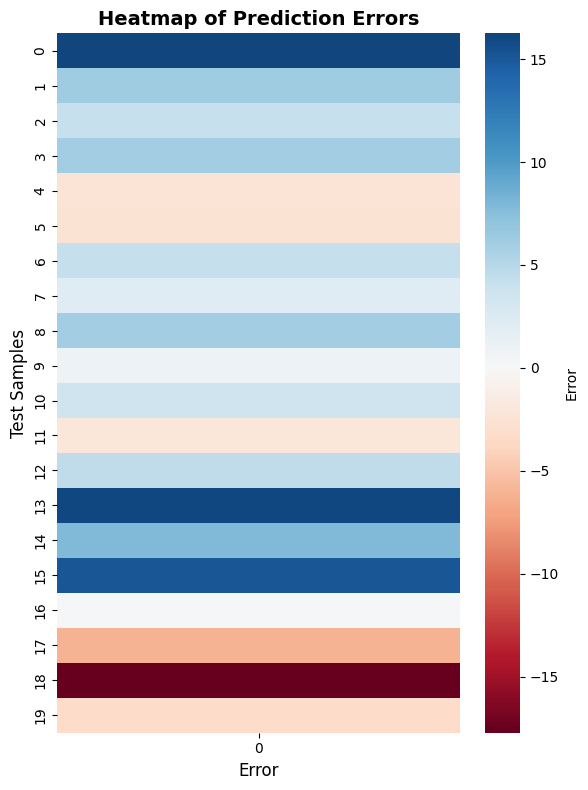

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

# Constants
N = 60
M = 1
LR = 0.0003
EPOCHS_CV = 75
EPOCHS_FINAL = 150
PATIENCE_CV = 7
PATIENCE_FINAL = 12
BATCH_SIZE = 16
DROPOUT = 0.3

# Data Loading and Preprocessing

train_data = pd.read_csv('Google_Stock_Price_Train.csv', parse_dates=['Date'])
test_data = pd.read_csv('Google_Stock_Price_Test.csv', parse_dates=['Date'])

train_data = train_data.sort_values('Date')
test_data = test_data.sort_values('Date')
train_data.set_index('Date', inplace=True)
test_data.set_index('Date', inplace=True)

numeric_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
for df in [train_data, test_data]:
    for col in numeric_cols:
        df[col] = df[col].astype(str).str.replace(',', '', regex=True)
    df[numeric_cols] = df[numeric_cols].astype(float)

# Feature Engineering
train_data['Return'] = train_data['Close'].pct_change().fillna(0)
test_data['Return'] = test_data['Close'].pct_change().fillna(0)
train_data['MA7'] = train_data['Close'].rolling(window=7).mean().fillna(method='bfill')
test_data['MA7'] = test_data['Close'].rolling(window=7).mean().fillna(method='bfill')

features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Return', 'MA7']
target = 'Close'

# Correlation Matrix
plt.figure(figsize=(10, 6))
corr_matrix = train_data[features].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Feature Correlation Heatmap", fontsize=14, fontweight='bold')
plt.show()

# Scaling data
scaler = MinMaxScaler((0, 1))
scaled_train = scaler.fit_transform(train_data[features].values)
scaled_test = scaler.transform(test_data[features].values)
target_idx = features.index(target)

def create_sequences(data, look_back=N, target_idx=target_idx, M=M):
    X_seq, y_seq = [], []
    for i in range(look_back, len(data)):
        X_seq.append(data[i-look_back:i, :])
        y_seq.append(data[i, target_idx])
    return np.array(X_seq), np.array(y_seq)

X_train_all, y_train_all = create_sequences(scaled_train, look_back=N, target_idx=target_idx, M=M)
combined_data = np.concatenate((scaled_train[-N:], scaled_test), axis=0)
X_test, y_test = create_sequences(combined_data, look_back=N, target_idx=target_idx, M=M)

# Dataset and DataLoader classes
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)

# Model Definitions

class VanillaRNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout):
        super(VanillaRNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, 1)
    def forward(self, x):
        out, _ = self.rnn(x)
        return self.fc(out[:, -1, :])

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, 1)
    def forward(self, x):
        out, (hn, cn) = self.lstm(x)
        return self.fc(out[:, -1, :])

class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, 1)
    def forward(self, x):
        out, _ = self.gru(x)
        return self.fc(out[:, -1, :])


# ross-Validation and Model Selection


def cross_validate(model_class, input_size, X, y, splits, hidden_size, num_layers, dropout, lr, epochs, patience):

    tscv = TimeSeriesSplit(n_splits=splits)
    val_losses = []

    for fold, (train_index, val_index) in enumerate(tscv.split(X)):
        print(f"Fold {fold + 1}/{splits}")

        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        # Create datasets and dataloaders
        train_dataset = TimeSeriesDataset(X_train, y_train)
        val_dataset = TimeSeriesDataset(X_val, y_val)
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

        # Initialize the model
        model = model_class(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout
        )

        # Train the model
        trained_model, best_val_loss = train_model(
            model,
            train_loader,
            val_loader,
            epochs=epochs,
            lr=lr,
            patience=patience
        )

        val_losses.append(best_val_loss)
        print(f"Fold {fold + 1} Validation Loss: {best_val_loss:.6f}\n")

    avg_val_loss = np.mean(val_losses)
    return avg_val_loss

def train_model(model, train_loader, val_loader, epochs, lr, patience):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.to(device)

    best_val_loss = float('inf')
    patience_counter = 0
    best_state = None

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            preds = model(X_batch).squeeze()
            loss = criterion(preds, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        val_loss = 0.0
        model.eval()
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                preds = model(X_batch).squeeze()
                val_loss += criterion(preds, y_batch).item()

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_state = model.state_dict()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch + 1}")
                break

    if best_state is not None:
        model.load_state_dict(best_state)
    return model, best_val_loss

# Define your cross-validation experiments
cv_experiments =[
      # Vanilla RNN configurations
    {"name": "RNN_50units_1layer_dropout0.0", "model": VanillaRNNModel, "hidden_size":50, "num_layers":1, "dropout":0.0},
    {"name": "RNN_100units_2layers_dropout0.2", "model": VanillaRNNModel, "hidden_size":100, "num_layers":2, "dropout":0.2},
    {"name": "RNN_200units_2layers_dropout0.1", "model": VanillaRNNModel, "hidden_size":200, "num_layers":2, "dropout":0.1},

    # LSTM configurations
    {"name": "LSTM_50units_1layer_dropout0.0", "model": LSTMModel, "hidden_size":50, "num_layers":1, "dropout":0.0},
    {"name": "LSTM_100units_2layers_dropout0.2", "model": LSTMModel, "hidden_size":100, "num_layers":2, "dropout":0.2},
    {"name": "LSTM_200units_2layers_dropout0.3", "model": LSTMModel, "hidden_size":200, "num_layers":2, "dropout":0.3},

    # GRU configurations
    {"name": "GRU_50units_1layer_dropout0.0", "model": GRUModel, "hidden_size":50, "num_layers":1, "dropout":0.0},
    {"name": "GRU_100units_2layers_dropout0.2", "model": GRUModel, "hidden_size":100, "num_layers":2, "dropout":0.2},
    {"name": "GRU_200units_1layer_dropout0.1", "model": GRUModel, "hidden_size":200, "num_layers":1, "dropout":0.1}
]

# Perform cross-validation for each experiment
cv_results = []
for exp in cv_experiments:
    print(f"Starting Cross-Validation for {exp['name']}...")
    val_error = cross_validate(
        model_class=exp["model"],
        input_size=len(features),
        X=X_train_all,
        y=y_train_all,
        splits=3,
        hidden_size=exp["hidden_size"],
        num_layers=exp["num_layers"],
        dropout=exp["dropout"],
        lr=LR,
        epochs=EPOCHS_CV,
        patience=PATIENCE_CV
    )
    cv_results.append((exp['name'], val_error))
    print(f"Completed Cross-Validation for {exp['name']}\n")

print("\nCross-Validation Results:")
for name, val_err in cv_results:
    print(f"{name}: Avg Val MSE = {val_err:.6f}")

# Select Best Model
best_cv_model = min(cv_results, key=lambda x: x[1])
print(f"\nBest model from CV: {best_cv_model[0]}")
best_config = next(item for item in cv_experiments if item['name'] == best_cv_model[0])

# Final train/val split
val_ratio = 0.15
val_size = int(len(X_train_all) * val_ratio)
train_size = len(X_train_all) - val_size
X_train_final, X_val_final = X_train_all[:train_size], X_train_all[train_size:]
y_train_final, y_val_final = y_train_all[:train_size], y_train_all[train_size:]

train_dataset_final = TimeSeriesDataset(X_train_final, y_train_final)
val_dataset_final = TimeSeriesDataset(X_val_final, y_val_final)
train_loader_final = DataLoader(train_dataset_final, batch_size=BATCH_SIZE, shuffle=True)
val_loader_final = DataLoader(val_dataset_final, batch_size=BATCH_SIZE, shuffle=False)

# Initialize and train the final model
final_model = best_config["model"](
    len(features),
    best_config["hidden_size"],
    best_config["num_layers"],
    best_config["dropout"]
)
final_model, _ = train_model(
    final_model,
    train_loader_final,
    val_loader_final,
    epochs=EPOCHS_FINAL,
    lr=LR,
    patience=PATIENCE_FINAL
)

# Test evaluation
test_dataset = TimeSeriesDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test_preds, test_actuals = [], []
final_model.eval()
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        preds = final_model(X_batch).squeeze().cpu().numpy()
        test_preds.extend(preds)
        test_actuals.extend(y_batch.numpy())
test_preds, test_actuals = np.array(test_preds), np.array(test_actuals)

# Inverse transform predictions and actuals
inverse_input_pred = np.zeros((len(test_preds), len(features)))
inverse_input_pred[:, target_idx] = test_preds
y_pred_inv = scaler.inverse_transform(inverse_input_pred)[:, target_idx]

inverse_input_true = np.zeros((len(test_actuals), len(features)))
inverse_input_true[:, target_idx] = test_actuals
y_true_inv = scaler.inverse_transform(inverse_input_true)[:, target_idx]

# Metrics
mse = mean_squared_error(y_true_inv, y_pred_inv)
mae = mean_absolute_error(y_true_inv, y_pred_inv)
mape = mean_absolute_percentage_error(y_true_inv, y_pred_inv) * 100
print(f"Test MSE: {mse:.4f}, MAE: {mae:.4f}, MAPE: {mape:.2f}%")

# Baseline performance (naive prediction: next day's price = previous day's price)
baseline_pred = np.roll(y_true_inv, 1)
baseline_pred[0] = y_true_inv[0]
baseline_mse = mean_squared_error(y_true_inv, baseline_pred)
baseline_mae = mean_absolute_error(y_true_inv, baseline_pred)
baseline_mape = mean_absolute_percentage_error(y_true_inv, baseline_pred) * 100
print("\nBaseline Performance:")
print(f"Baseline MSE: {baseline_mse:.4f}")
print(f"Baseline MAE: {baseline_mae:.4f}")
print(f"Baseline MAPE: {baseline_mape:.2f}%")

# Plot Actual vs Predicted Prices
plt.figure(figsize=(10, 6))
plt.plot(y_true_inv, label='Actual', color='blue', linewidth=2)
plt.plot(y_pred_inv, label='Predicted (Model)', color='red', linewidth=2)
plt.plot(baseline_pred, label='Predicted (Baseline)', color='green', linestyle='--', linewidth=2)
plt.title('Actual vs Predicted Prices', fontsize=14, fontweight='bold')
plt.xlabel('Test Steps', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

# Scatter plot of predictions vs actual values
plt.figure(figsize=(6, 6))
plt.scatter(y_true_inv, y_pred_inv, alpha=0.5, color='purple')
plt.title('Predictions vs Actual', fontsize=14, fontweight='bold')
plt.xlabel('Actual Price', fontsize=12)
plt.ylabel('Predicted Price', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Heatmap of prediction errors
errors = y_true_inv - y_pred_inv
errors_reshaped = errors.reshape(-1, 1)
plt.figure(figsize=(6, 8))
sns.heatmap(errors_reshaped, cmap='RdBu', center=0, cbar_kws={'label': 'Error'})
plt.title('Heatmap of Prediction Errors', fontsize=14, fontweight='bold')
plt.xlabel('Error', fontsize=12)
plt.ylabel('Test Samples', fontsize=12)
plt.tight_layout()
plt.show()
